In [33]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Exploratory Data Analysis
Looking first at the layout of the data, and the types of each column

In [4]:
train.head()

,id,Decision,Host_response_time,Host_is_superhost,Host_has_profile_pic,Host_identity_verified,Neighbourhood,Property_type,Room_type,Accommodates,...,Beds,Essentials,Cooking,Balcony,Parking,Price,Number_of_reviews,Review_scores_rating,Instant_bookable,Month
0,1,1,within an hour,t,t,t,28806,Entire cabin,Entire home/apt,6,...,3.0,5,5,1,1,$164.00,90,4.93,t,August
1,2,1,within an hour,t,t,t,28804,Entire house,Entire home/apt,4,...,1.0,5,4,1,1,$101.00,522,4.69,t,June
2,3,0,within a few hours,t,t,t,28806,Private room in bungalow,Private room,1,...,1.0,5,3,1,1,$32.00,35,4.83,f,June
3,4,1,within an hour,t,t,t,28803,Entire condominium (condo),Entire home/apt,8,...,5.0,5,5,0,1,$381.00,11,5.00,t,September
4,5,0,within an hour,t,t,t,28805,Entire house,Entire home/apt,6,...,4.0,5,5,1,1,$238.00,63,4.70,f,July


In [5]:
train.describe()

,id,Decision,Neighbourhood,Accommodates,Bedrooms,Beds,Essentials,Cooking,Balcony,Parking,Number_of_reviews,Review_scores_rating
count,7471.000000,7471.000000,7471.000000,7471.000000,6886.000000,7458.000000,7471.000000,7471.000000,7471.000000,7471.000000,7471.000000,7076.000000
mean,3736.000000,0.633784,28793.443180,4.293267,1.837932,2.289890,4.723598,3.626824,0.632044,0.958506,87.481997,4.881412
std,2156.836263,0.481802,29.064001,2.762739,1.125600,1.738629,0.617703,1.627228,0.482282,0.199443,107.129371,0.238291
min,1.000000,0.000000,28704.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1868.500000,0.000000,28801.000000,2.000000,1.000000,1.000000,5.000000,3.000000,0.000000,1.000000,13.000000,4.850000
50%,3736.000000,1.000000,28804.000000,4.000000,1.000000,2.000000,5.000000,4.000000,1.000000,1.000000,50.000000,4.930000
75%,5603.500000,1.000000,28806.000000,6.000000,2.000000,3.000000,5.000000,5.000000,1.000000,1.000000,121.000000,4.990000
max,7471.000000,1.000000,28806.000000,16.000000,9.000000,18.000000,5.000000,5.000000,1.000000,1.000000,1059.000000,5.000000


In [6]:
train.dtypes

id                          int64
Decision                    int64
Host_response_time         object
Host_is_superhost          object
Host_has_profile_pic       object
Host_identity_verified     object
Neighbourhood               int64
Property_type              object
Room_type                  object
Accommodates                int64
Bathrooms_text             object
Bedrooms                  float64
Beds                      float64
Essentials                  int64
Cooking                     int64
Balcony                     int64
Parking                     int64
Price                      object
Number_of_reviews           int64
Review_scores_rating      float64
Instant_bookable           object
Month                      object
dtype: object

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7471 entries, 0 to 7470
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7471 non-null   int64  
 1   Decision                7471 non-null   int64  
 2   Host_response_time      6613 non-null   object 
 3   Host_is_superhost       7375 non-null   object 
 4   Host_has_profile_pic    7375 non-null   object 
 5   Host_identity_verified  7375 non-null   object 
 6   Neighbourhood           7471 non-null   int64  
 7   Property_type           7471 non-null   object 
 8   Room_type               7471 non-null   object 
 9   Accommodates            7471 non-null   int64  
 10  Bathrooms_text          7471 non-null   object 
 11  Bedrooms                6886 non-null   float64
 12  Beds                    7458 non-null   float64
 13  Essentials              7471 non-null   int64  
 14  Cooking                 7471 non-null   

### First observations from the data

1. There are 21 columns including the Decision column which is the class we want to predict. 
2. Many of these columns are binary, either having 't'/'f' or 0/1 values. We need to standardise the binarization.
3. There are some columns with large number of null values - close to 10% of the taining data. Need to figure out the reason for that and possible imputation

## Null value analysis

In [8]:
train.isna().sum()

id                          0
Decision                    0
Host_response_time        858
Host_is_superhost          96
Host_has_profile_pic       96
Host_identity_verified     96
Neighbourhood               0
Property_type               0
Room_type                   0
Accommodates                0
Bathrooms_text              0
Bedrooms                  585
Beds                       13
Essentials                  0
Cooking                     0
Balcony                     0
Parking                     0
Price                       0
Number_of_reviews           0
Review_scores_rating      395
Instant_bookable            0
Month                       0
dtype: int64

The most number of null values are in Host_response_time, which is a categorical variable. After that, the null values are in number of Bedrooms and Review_scores_rating. At first glance, it appears that number of Bedrooms and Review_scores_rating could be genuine missing values - that the houses may not contain any Bedrooms or have no ratings available. 

Also, it will be interesting to see how the null values are distributed. Are there rows where all these values are missing? Such rows can be possible targets for either imputation or removal during training.

To see how the null values are linked to each other, plot a correlation heatmap of just the null values. Use `missingno` to plot the heatmap

<AxesSubplot:>

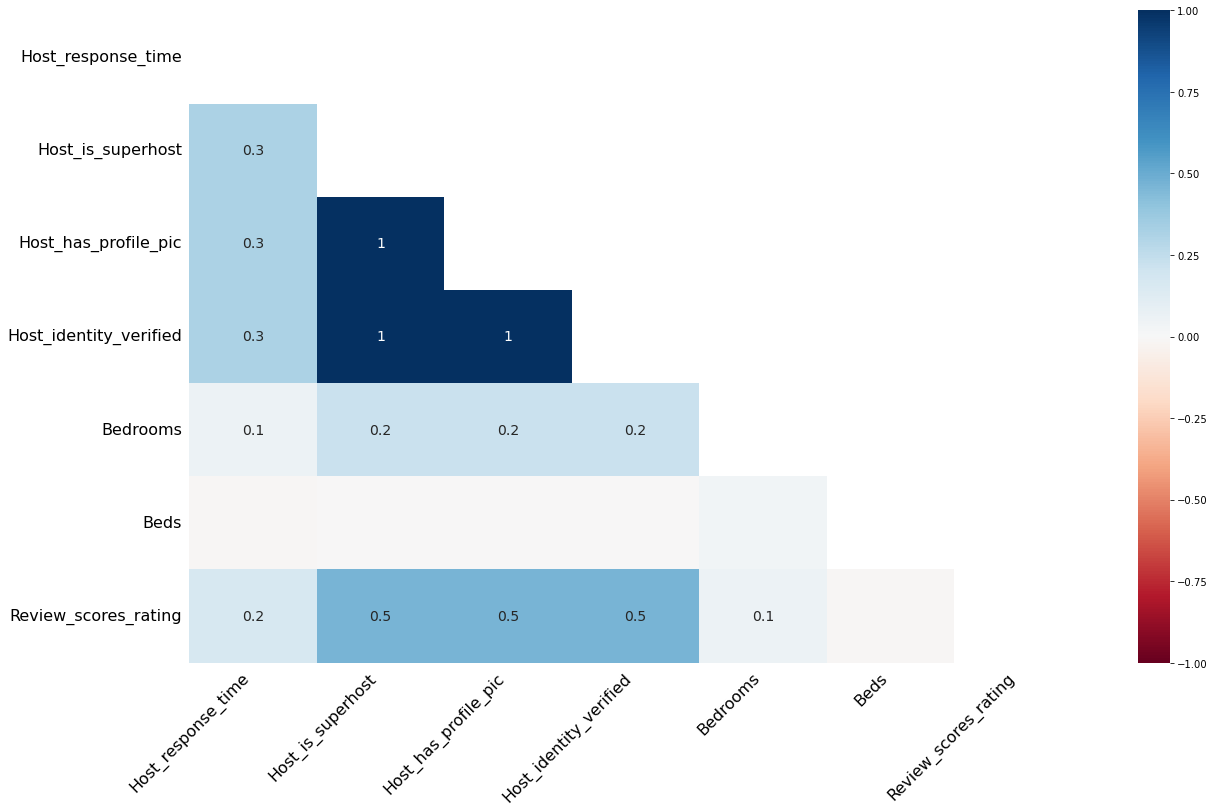

In [10]:
msno.heatmap(train)

### Null value heatmap 
This plot shows what percentage of attribute on the y-axis is missing when the attribute on the x-axis is missing. Some observations from here -
1. When host_is_superhost is NA, host_has_profile_pic and host_has_identity_verified are also NA. This means that the information for this host is not available. 
    - As all these are binary t/f values, we can safely impute them as False
2. Host_response_time is NA 1/3rd of the time for our missing identity hosts.
3. Review scores are missing for missing identity hosts half the time as well.

### Plotting the distribution of Decision with the NA values in the columns

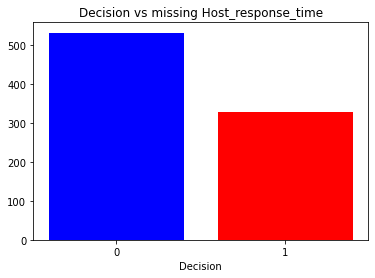

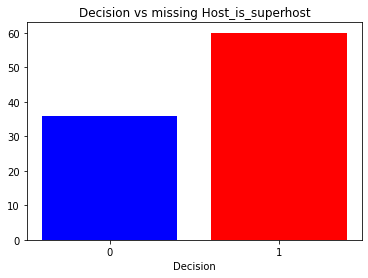

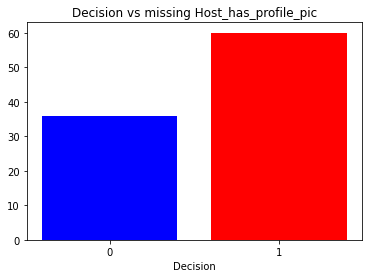

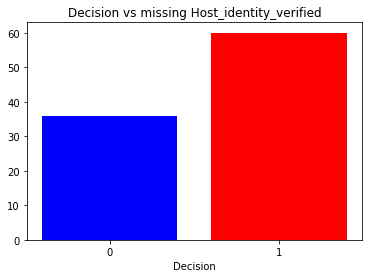

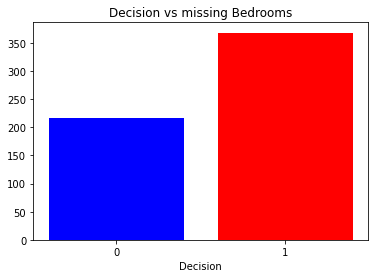

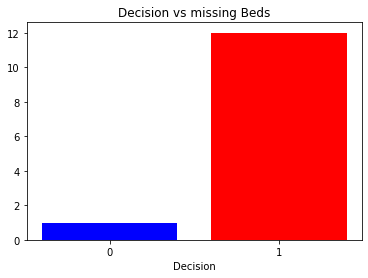

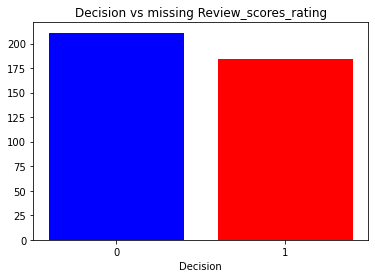

In [97]:
for i in train.columns:
    sub = train[train[i].isna()]
    if len(sub)>0:
        plt.bar(np.array((0,1)),np.bincount(sub.Decision), color = ['b','r'])
        plt.xticks(np.array((0,1)), ["0","1"])
        plt.xlabel("Decision")
        plt.title("Decision vs missing {}".format(i))
        plt.show()

### Observations
From the above plots, it is clear that the missin values of Host_response_time are critical because they disproportionately reflect Decision 0. In the overall dataset, Decision 1 is present 63% of the time, and a feature which disproportionately represents Decision 0, the minority decision, is becomes critical.

Similarly, missing review scores rating values are also important

# Preprocessing - encoding and filling NA values

Preprocessing steps -
1. Impute missing values - Fill with 'F'/0 
2. Label encode - Ordinal variables and boolean variables are Label encoded - this preserves the ordering characteristics
3. One-hot encode - Categorical variables like Neighbourhood, Room_type, Month are 1-hot encoded


In [98]:
def preprocessing(data):
    le = LabelEncoder()
    
    ## Host response time
    ### Fill NA with blank
    ### Label encode them - NA is 0
    data['Host_response_time'] = data['Host_response_time'].fillna('')
    data['Host_response_time'] = le.fit_transform(data['Host_response_time'])
    
    ## Host is superhost
    ### Fill NA with false
    ### Label encode them 
    data.Host_is_superhost = data.Host_is_superhost.fillna('f')
    data.Host_is_superhost = le.fit_transform(data.Host_is_superhost)

    ## Host has profile pic
    ### Fill NA with false
    ### Label encode them 
    data.Host_has_profile_pic = data.Host_has_profile_pic.fillna('f')
    data.Host_has_profile_pic = le.fit_transform(data.Host_has_profile_pic)

    ## Host has identity verified
    ### Fill NA with false
    ### Label encode them 
    data.Host_identity_verified = data.Host_identity_verified.fillna('f')
    data.Host_identity_verified = le.fit_transform(data.Host_identity_verified)
    
    ## Neighbourhood
    ### One-hot encode them, dropping the first column
    one_hot_neighbourhood = pd.get_dummies(data.Neighbourhood, prefix = "zip", drop_first=True,dtype='int64')
    data = data.drop('Neighbourhood', axis = 1)
    data = data.join(one_hot_neighbourhood)
    
    ## Property type
#     data.Property_type = data.Property_type.str.replace(" \(condo\)","")
#     data.Property_type = data.Property_type.str.replace(" \(Cuba\)","")
#     one_hot_prop_type = pd.get_dummies(data.Property_type, prefix = "prop", drop_first=True,dtype='int64')
#     data = data.drop('Property_type', axis = 1)
#     data = data.join(one_hot_prop_type)
    
    ## Room type
    ### One-hot encode them, dropping the first column
    one_hot_room_type = pd.get_dummies(data.Room_type, prefix = "room", drop_first=True,dtype='int64')
    data = data.drop('Room_type', axis = 1)
    data = data.join(one_hot_room_type)
    
    ## Bathrooms text
    ### Create 2 features Num_baths and Shared_bath
    ### Num_baths : number of bathrooms
    ### Shared_bath : whether bathrooms are shared
    data["Shared_bath"] = 0
    mask = data.Bathrooms_text.str.contains("shared")
    data.loc[mask, "Shared_bath"] = 1
    
    data["Num_baths"] = data.Bathrooms_text.str.extract('(\d*\.\d+|\d+)',expand = False).astype('float')
    
    mask = data.Bathrooms_text.str.contains("alf-bath")
    data.loc[mask, 'Num_baths'] = 0.5
    
    data = data.drop('Bathrooms_text', axis = 1)
    
    ## Bedrooms
    ### Fill NA with 0
    data.Bedrooms.fillna(0, inplace=True)
    
    ## Beds
    ### Fill NA with 0
    data.Beds.fillna(0, inplace = True)
    
    ## Price
    ### Convert to float
    data.Price = data.Price.replace('[\$,]', '', regex=True).astype(float)
    
    ## Review scores rating - drop where missing
#     data = data[data.Review_scores_rating.notna()]
    
    ## Instant bookable
    ### Label encode
    data.Instant_bookable = le.fit_transform(data.Instant_bookable)
    
    ## Month
    ### One-hot encode
    one_hot_month_type = pd.get_dummies(data.Month, prefix = "month", drop_first=True, dtype='int64')
    data = data.drop('Month', axis = 1)
    data = data.join(one_hot_month_type)
    
    ## Drop id, proporty_type, review_scores_rating
    data = data.drop(["id","Property_type","Review_scores_rating"], axis = 1)

    return data

In [99]:
train = preprocessing(train)

## More EDA

No handles with labels found to put in legend.


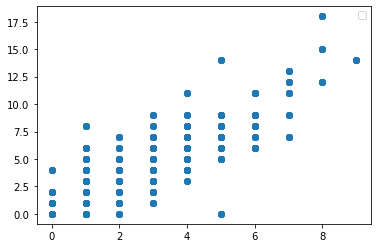

In [104]:
plt.scatter(train['Bedrooms'],train['Beds'])
plt.legend()
plt.show()

What impact to each of the features have on the decision?

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


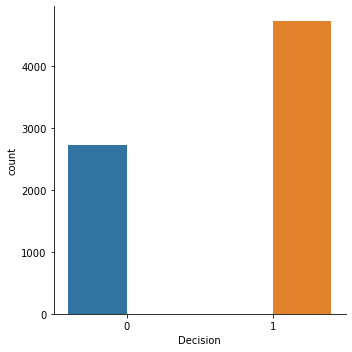

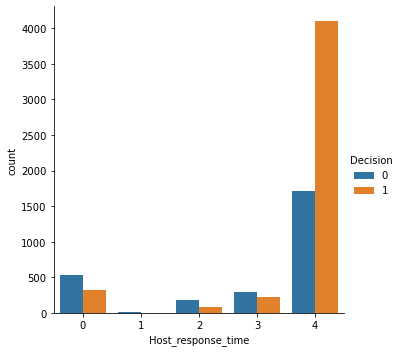

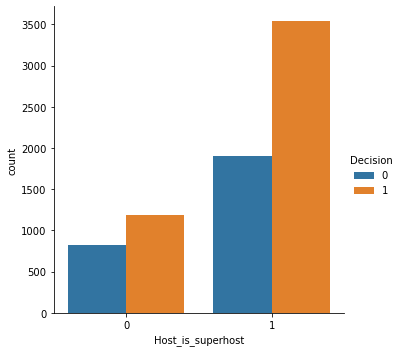

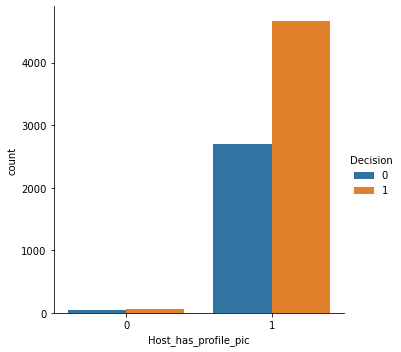

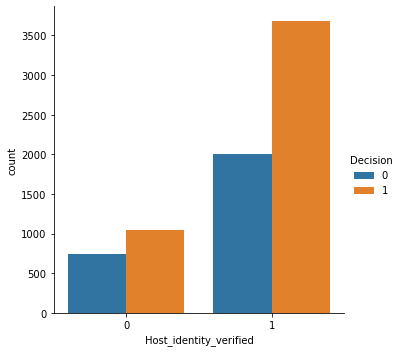

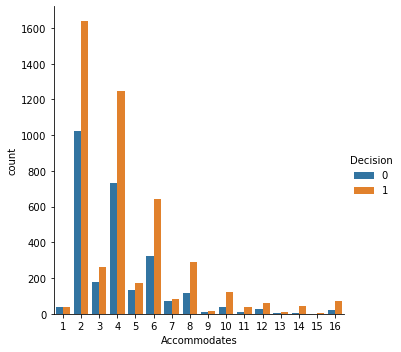

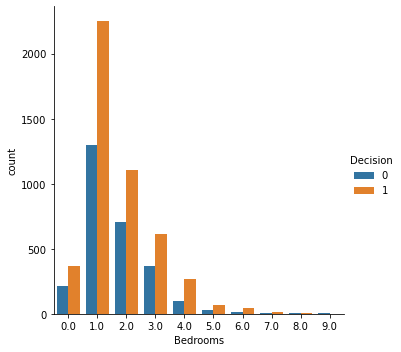

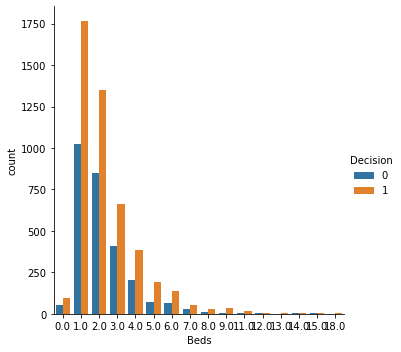

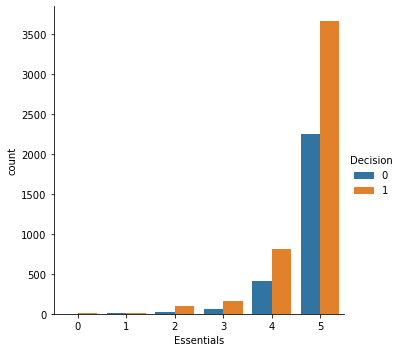

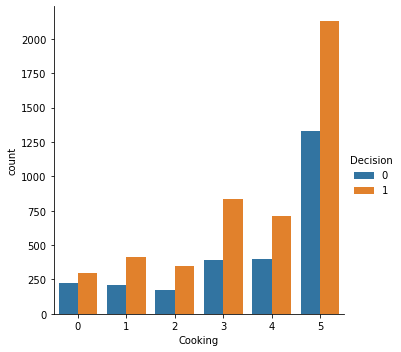

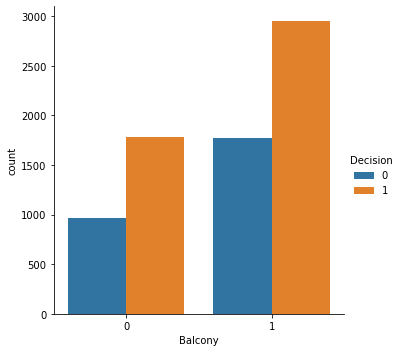

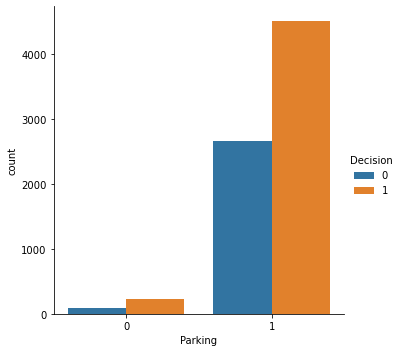

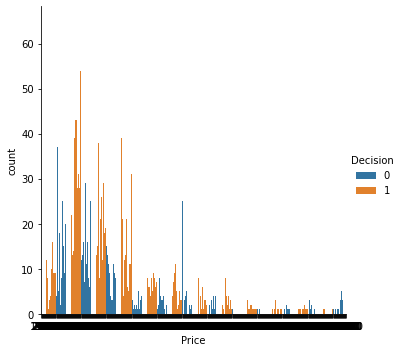

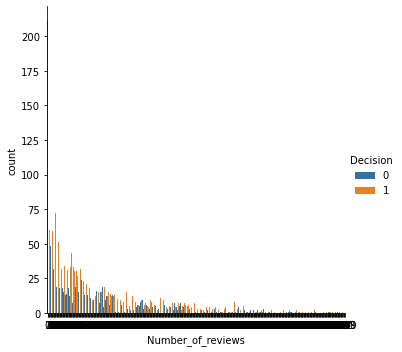

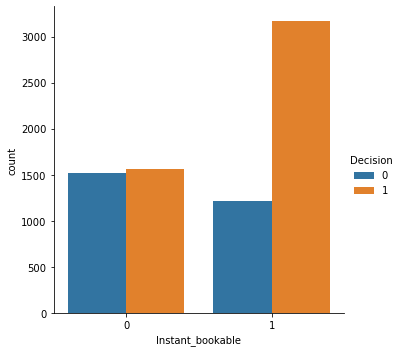

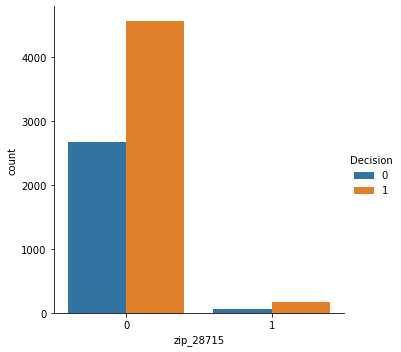

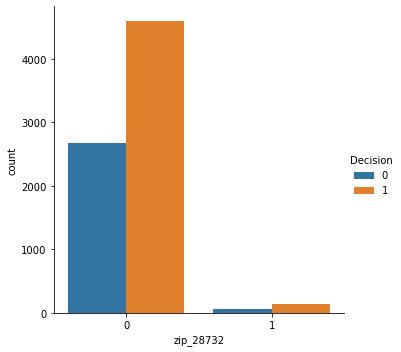

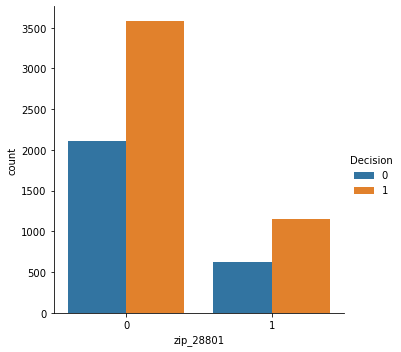

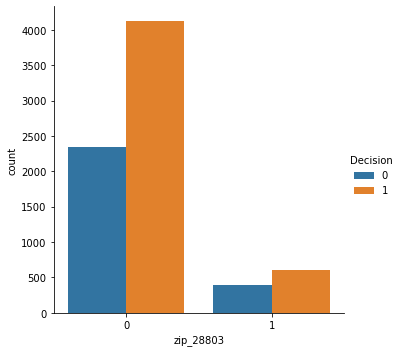

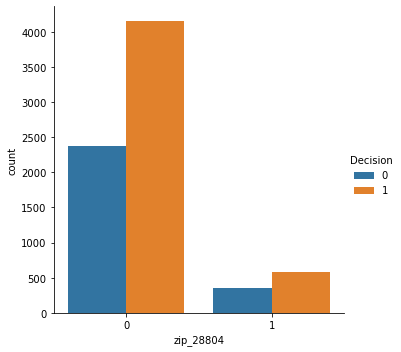

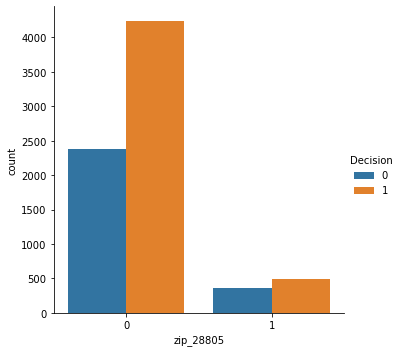

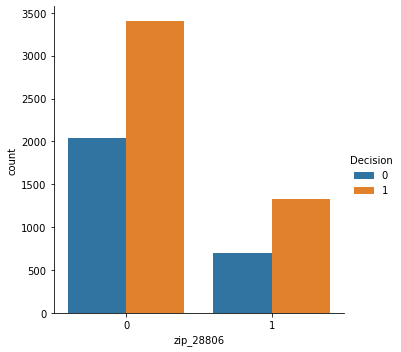

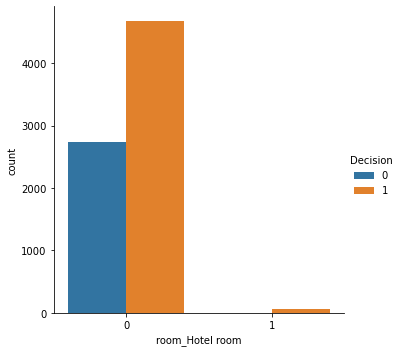

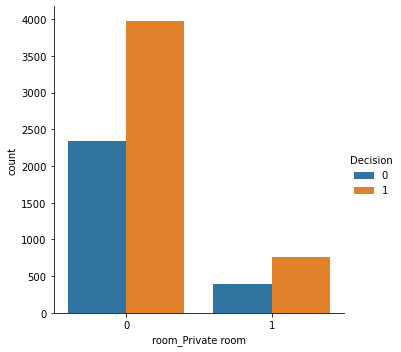

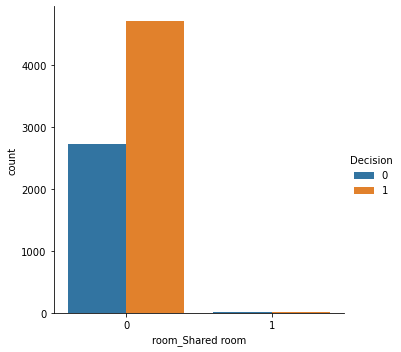

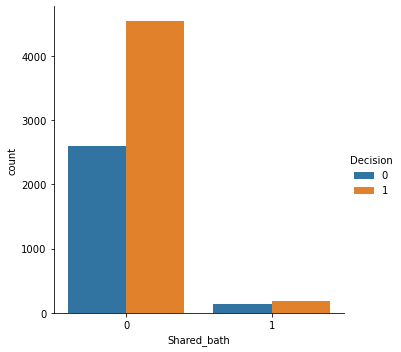

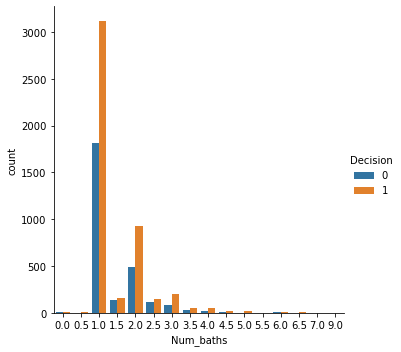

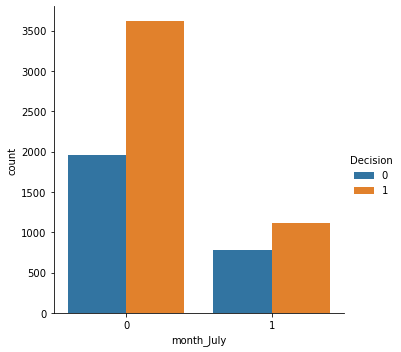

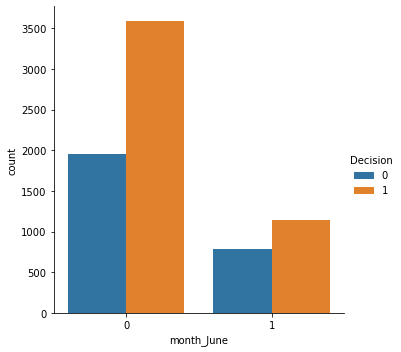

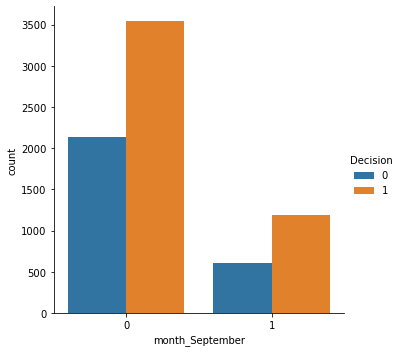

In [107]:
for i in range(len(train.columns)):
    sns.catplot(x=train.columns[i],hue='Decision',data=train,kind="count")

How do the features relate to each other?

In [109]:
train.columns

Index(['Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Accommodates',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Instant_bookable', 'zip_28715',
       'zip_28732', 'zip_28801', 'zip_28803', 'zip_28804', 'zip_28805',
       'zip_28806', 'room_Hotel room', 'room_Private room', 'room_Shared room',
       'Shared_bath', 'Num_baths', 'month_July', 'month_June',
       'month_September'],
      dtype='object')

In [110]:
variables = ['Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Instant_bookable']

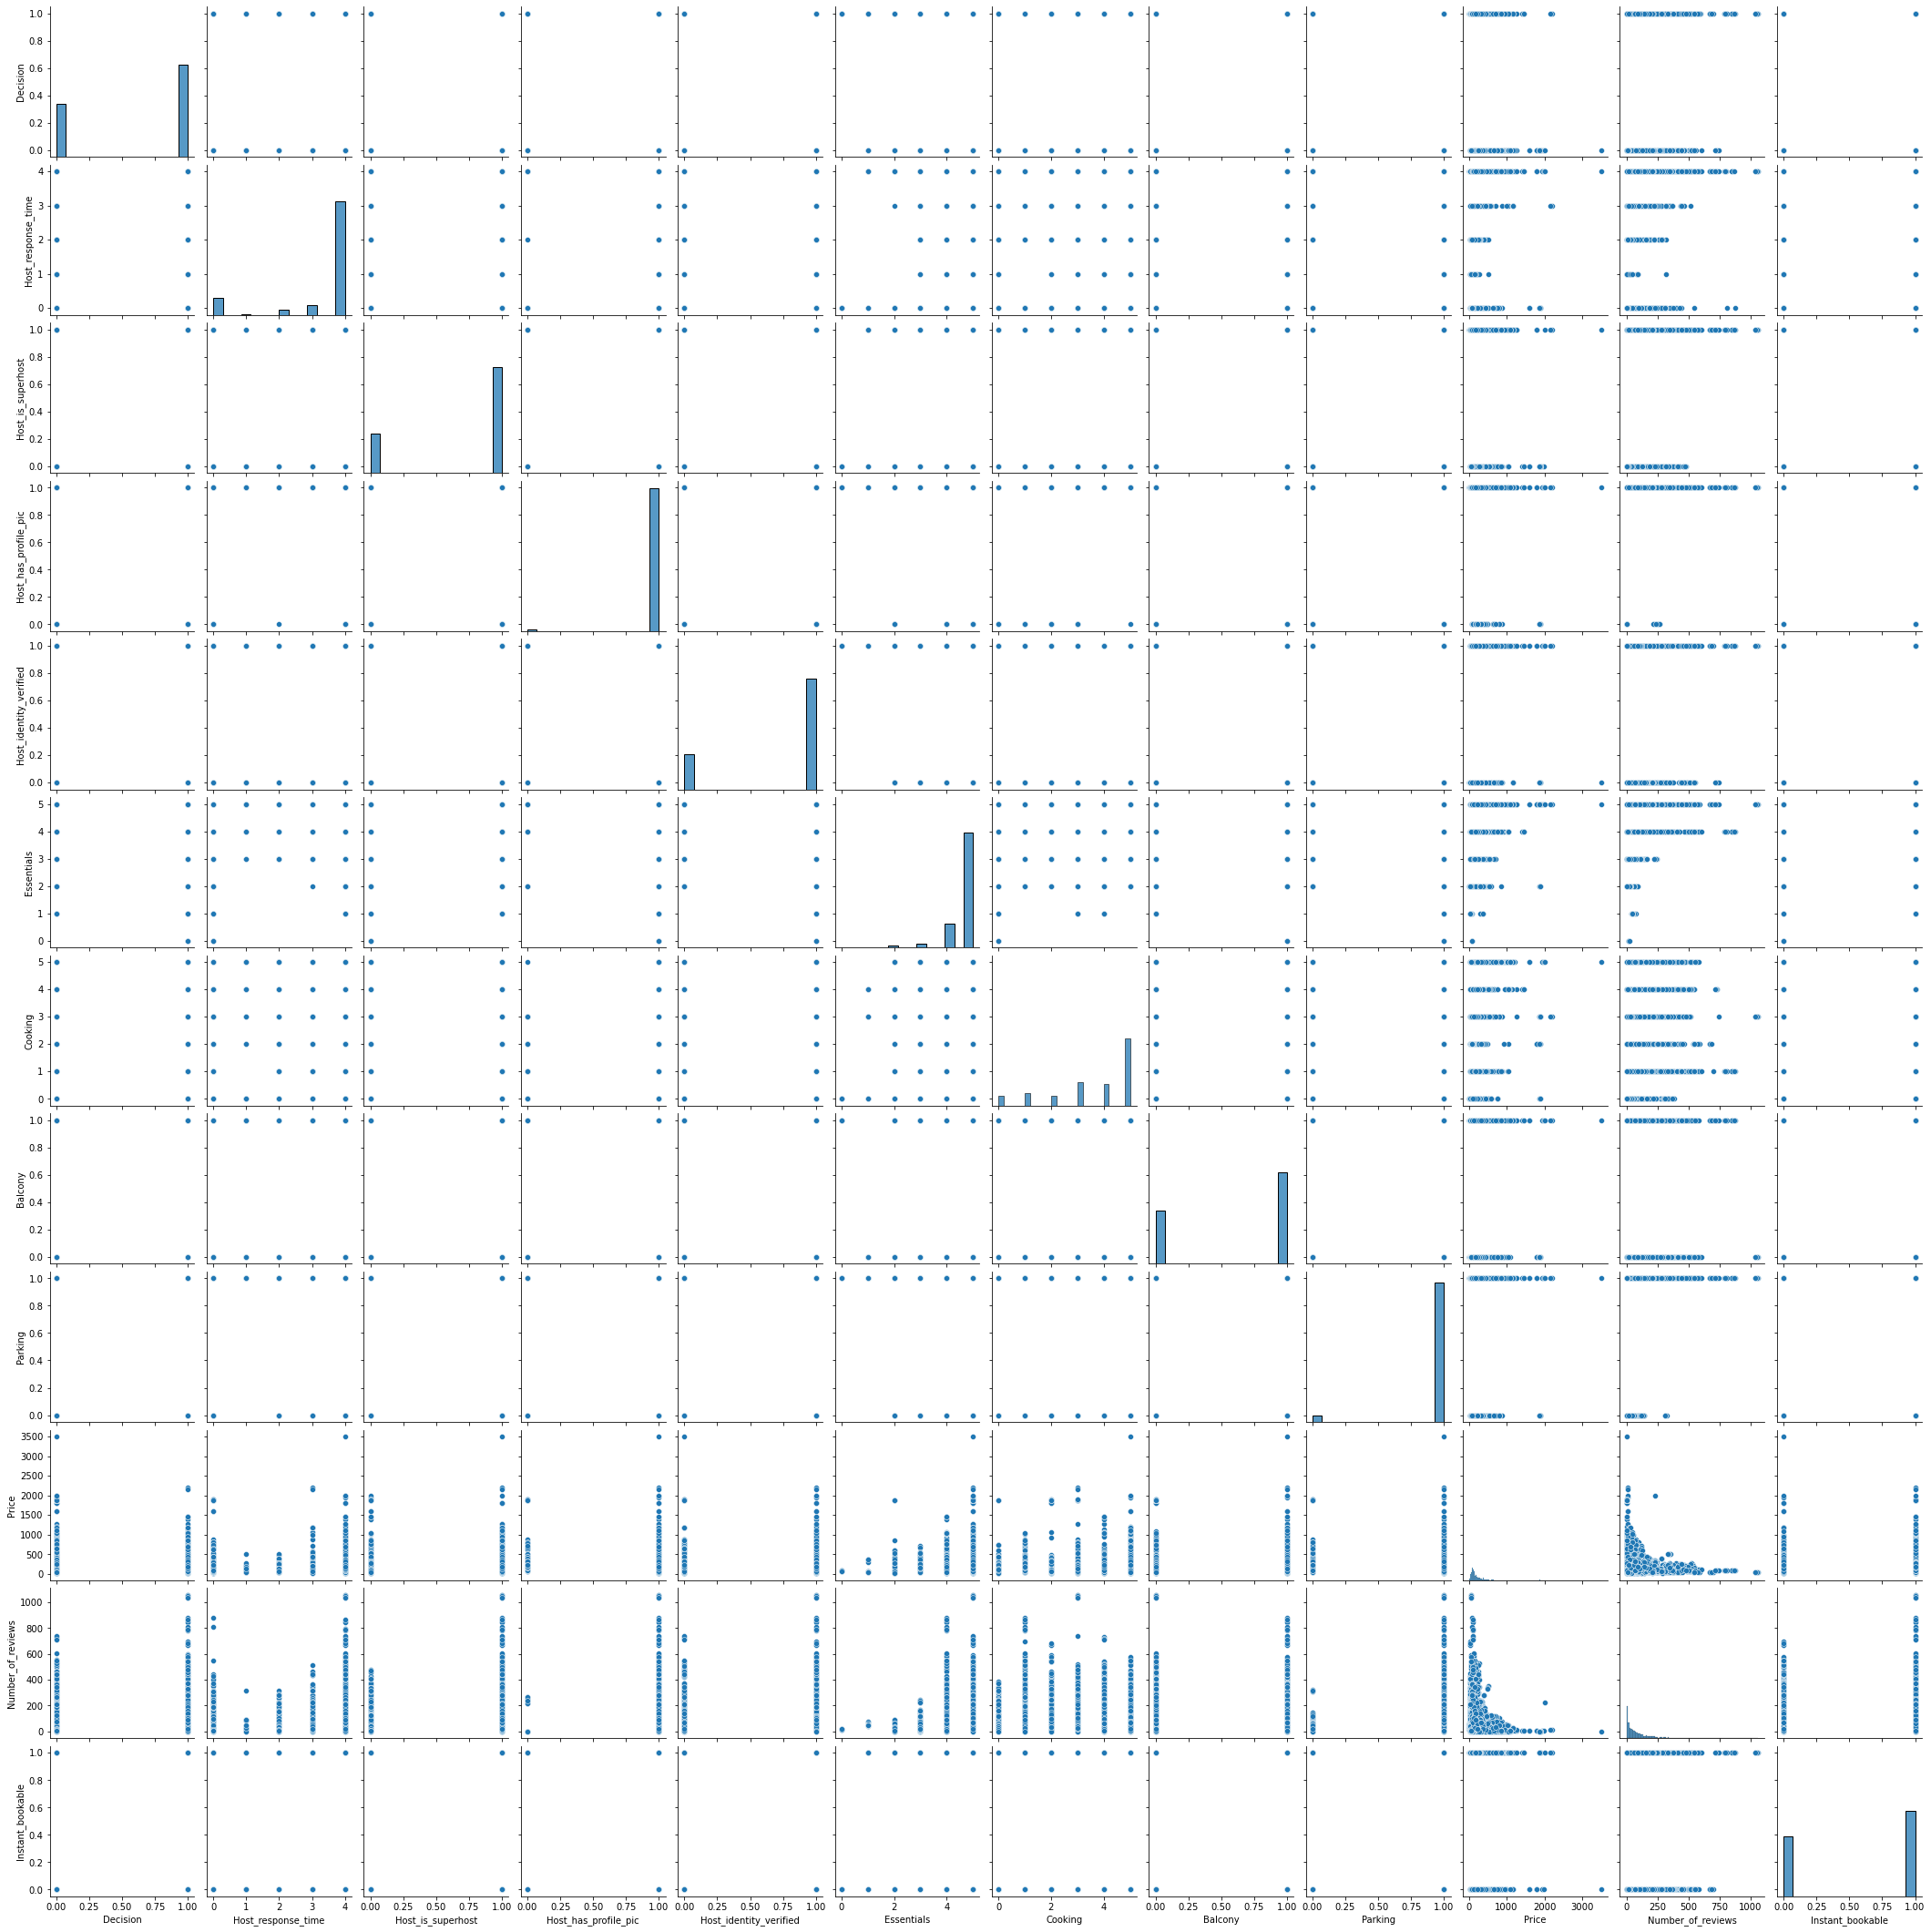

In [111]:
sns.pairplot(train, vars=variables)